# Convolution Neural Network

## Model Specification

The difference between a CNN and a regular MLP is that CNN has sub network of neurons that serve as **filters** (thus these neurons are sometimes just called filters or **kernels**) with small **reception fields** that scan the initial input, identifying basic patterns. Subsequent layers in CNN then combine the basic patterns and recognize more complex patterns. The number of filters at each layer is a hyper-parameter. The result of each filter is sometimes called a **feature map**. The fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. In contrast, once a regular DNN has learned to recognize a pattern in one location, it can recognize it only in that particular location.

- **Convolutional layers**: layers with the sub network, or neurons with shared weights, that scans with **stride** and **(typically zero) pad**. First level neurons scan the input, while higher-level neurons scan the 'maps' formed by lower-level neurons. Output dimension follows this relation:
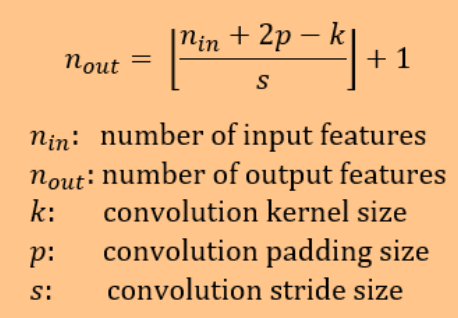
The number of neurons, or filters is typically a power of 2, such as 2, 4, 6, 8, etc. - note that this is also called the number of **channels** And filters are typically $5\times 5$ or $3\times 3$. Note that later neurons in the models are also called **activation maps**.
- **Pooling, or downsampling layers**: after each conv layer, it can be optionally followed by a 'max' or any other 'pooling' operation to collect information across the map, such as mean, p-norm (the harmonic average to the power of p) or even yet another tiny neural net. Another motivation for such pooling layer is to reduce layer size to reduce the amount of parameters and computation in the network, which helps prevent overfitting. But recently, the trend seems to be to not use pooling at all, while instead rely on fully conv nets with large stride once in a while to reduce the size of representation. Discarding pooling layers has also been found to be important in training good generative models, such as VAE and GAN. See [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) for more details.

Backprop for CNN is just regular convolution running on shifted derivative maps using flipped filter.

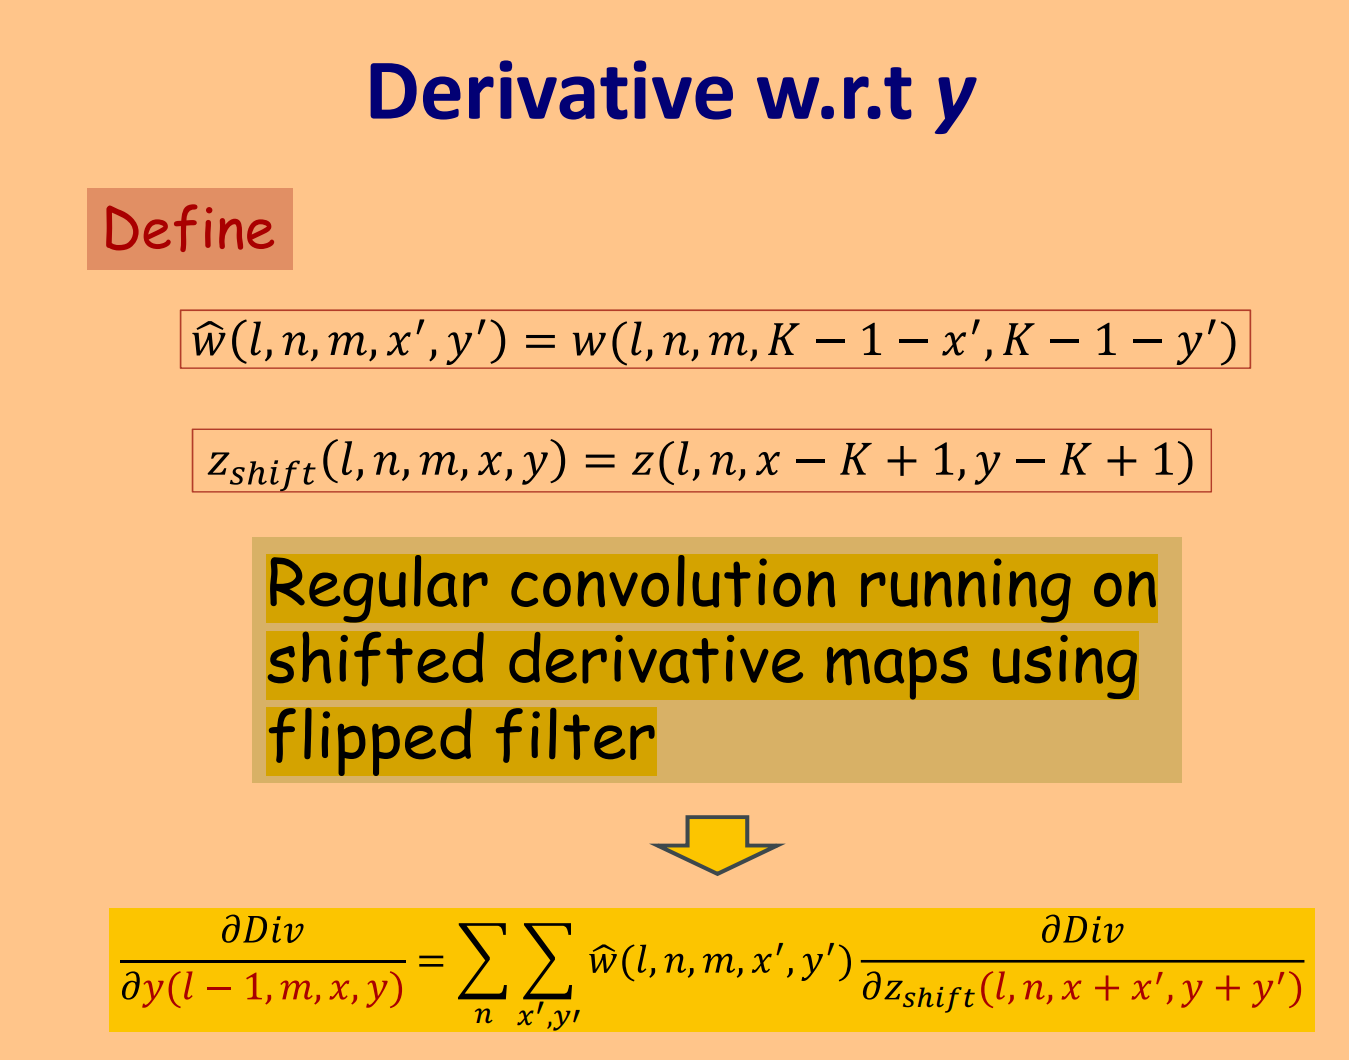

### Variants and Generalizations

#### Transposed Convolution

**ransposed convolution**, also called **fractionally-strided convolution**, or **deconvolution** (this is a mis-nomer but people keep calling it that). The purpose is to enlarge the layer size; see figure below, where the padded inputs are typically zeroed. Note that this is not the inverse operation of convolution! The reason that it is called 'transposed' can be found in a saved evernote for the 2D case and in the below for the 1D case.

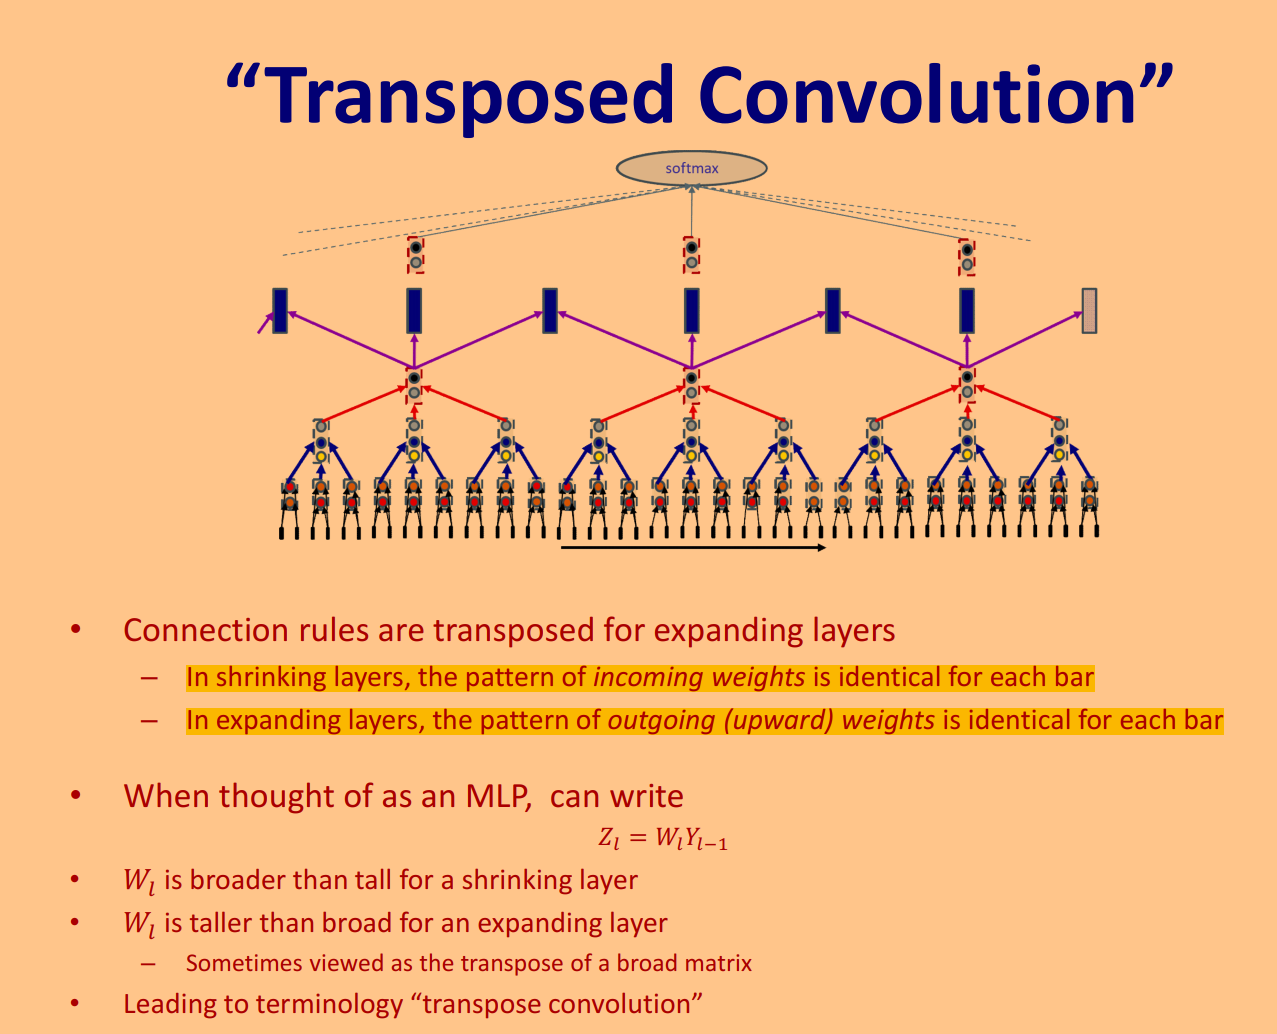

The two applications for transposed convolutional network is (1) Visualization with a Deconvnet: Visualizing and Understanding Convolutional Networks; (2) Deep convolutional generative adversarial networks. Both of them require increasing the size of representation.

#### 1x1 Convolution

Mainly used to reduce the depth, or the number of channels in image representation, while having no spatial extent. Another variant of this is depth-wise convolution: use 2D filters to scan all previous channels **independently**, then use 1x1 convolution layer to change the number of channels. The basic motivation is perhaps to reduce the number of parameters.

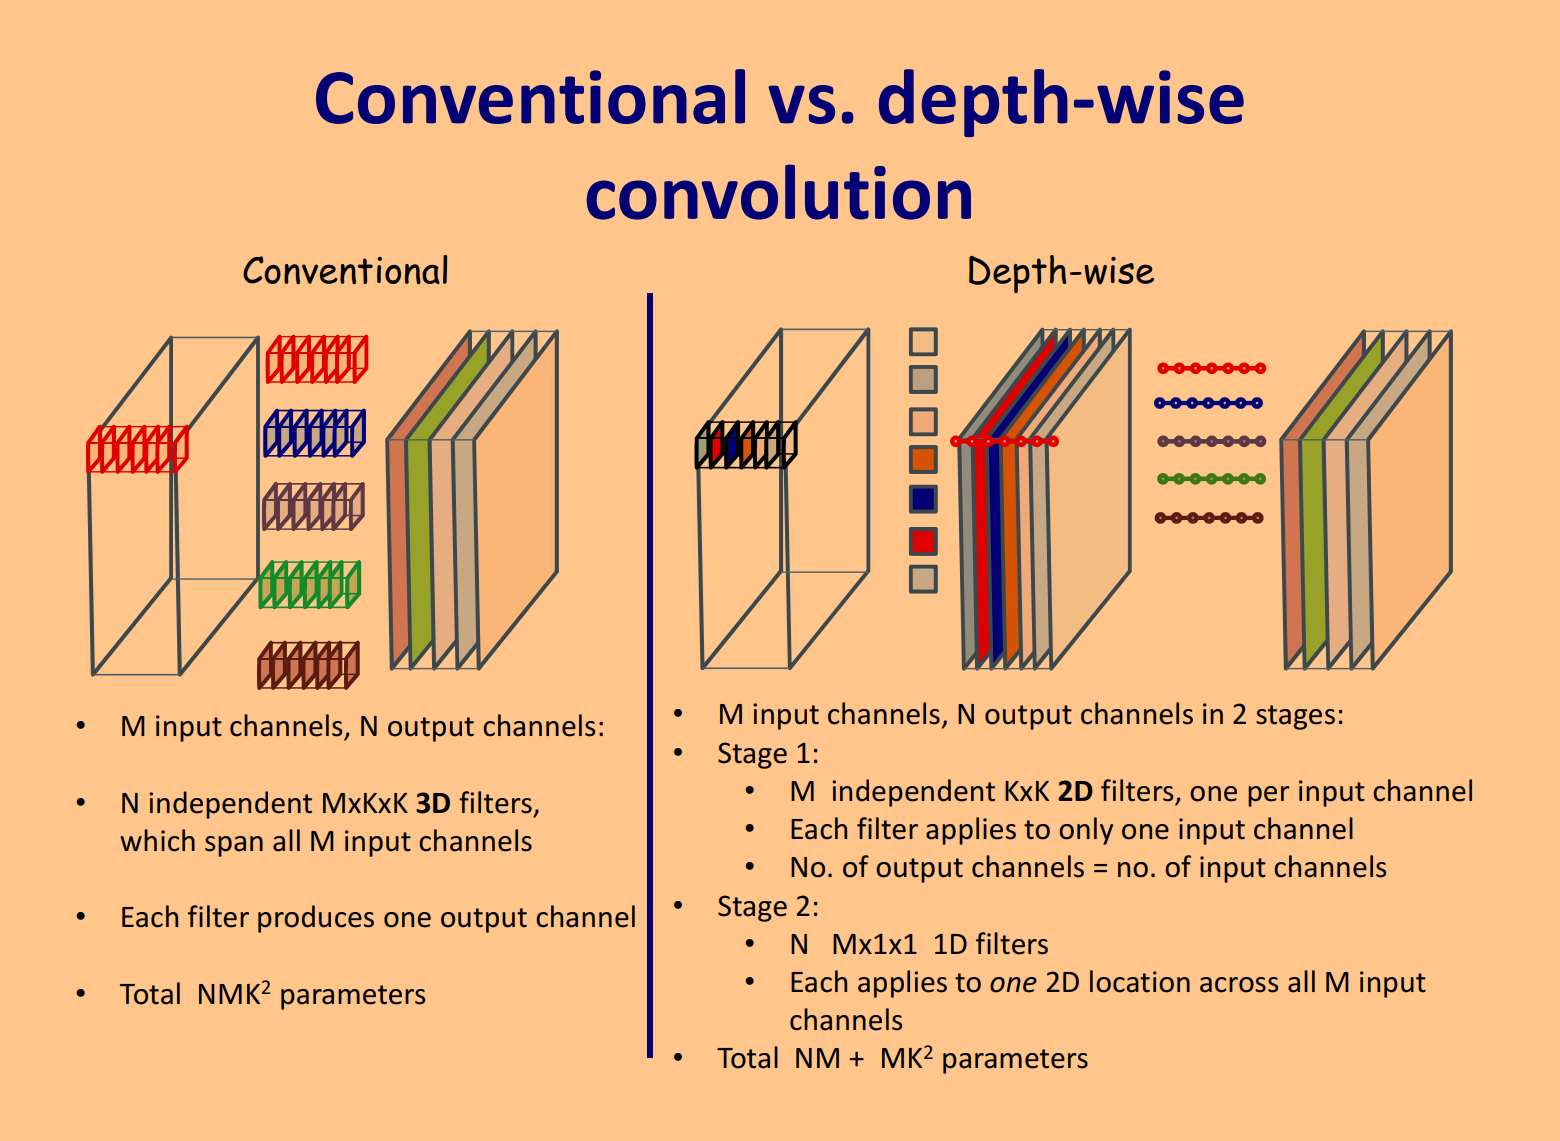

#### LeNet

Early neural net that starts the horserace, only a few layers.

#### AlexNet

- Use of ReLu
- Number of Parameters explode
- dropout of 0.5
- large amount of data augmentation
- SGD with mini-batch of 128
- momentum with factor of 0.9
- L2 regularization
- learning rate of 0.01 with plateau scheduling

#### VGGNet - reinforce the idea that CNNs must be deep in order to work well on visual data

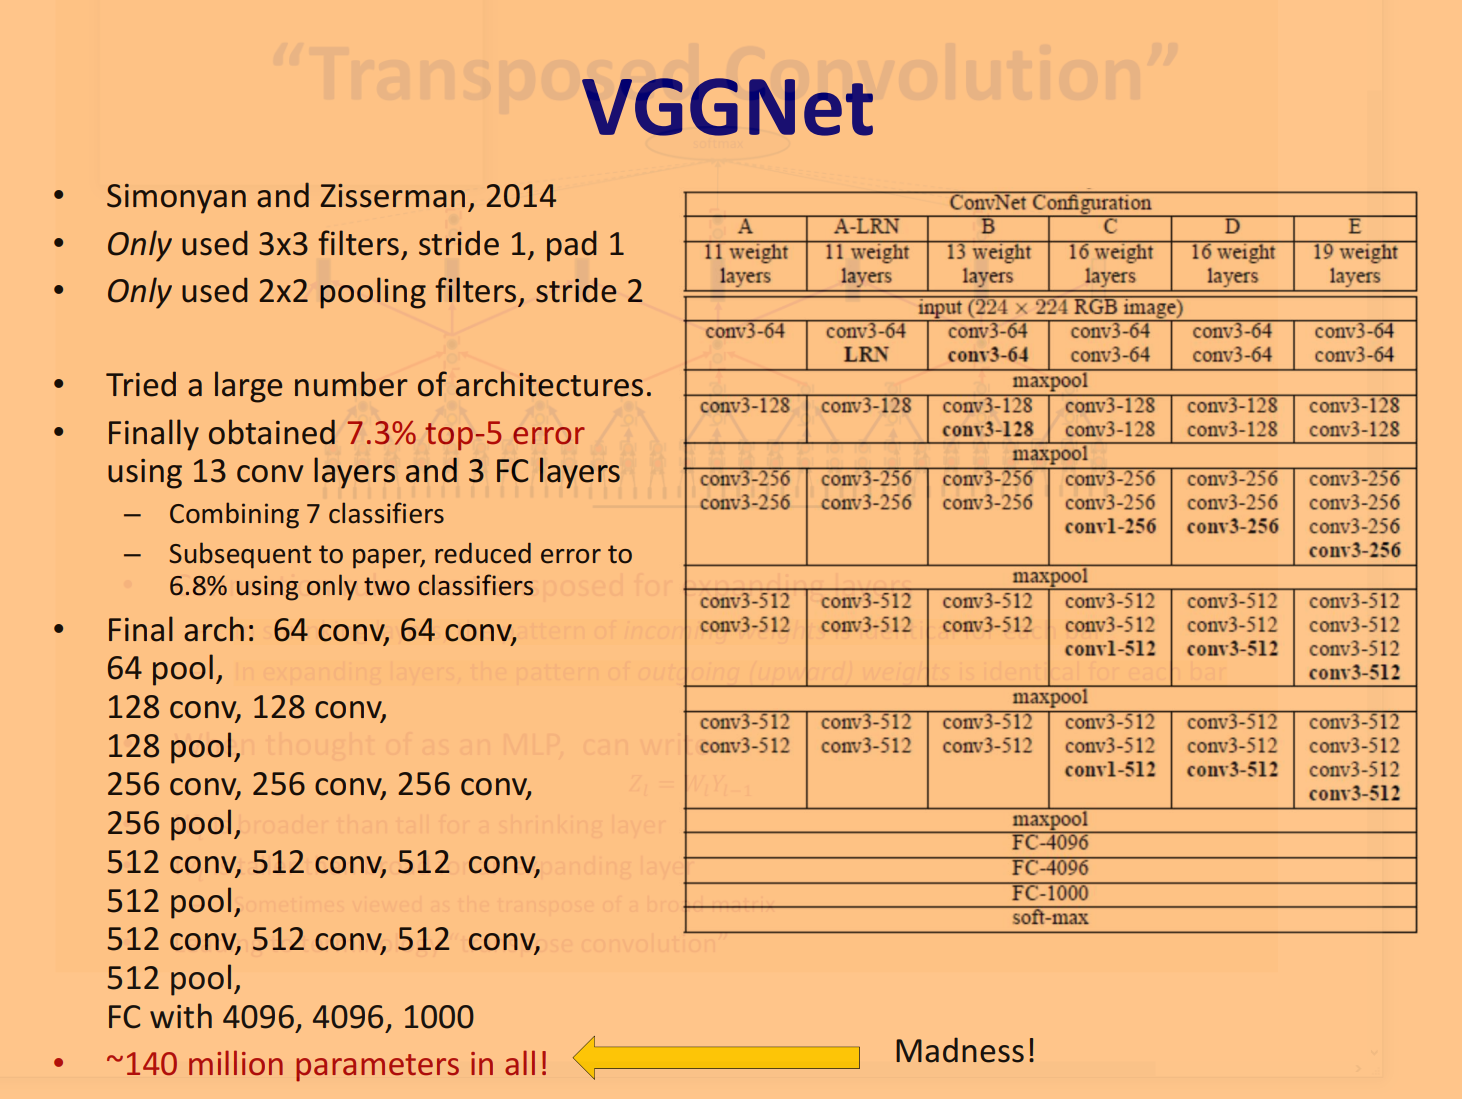

#### GoogleNet - Inception

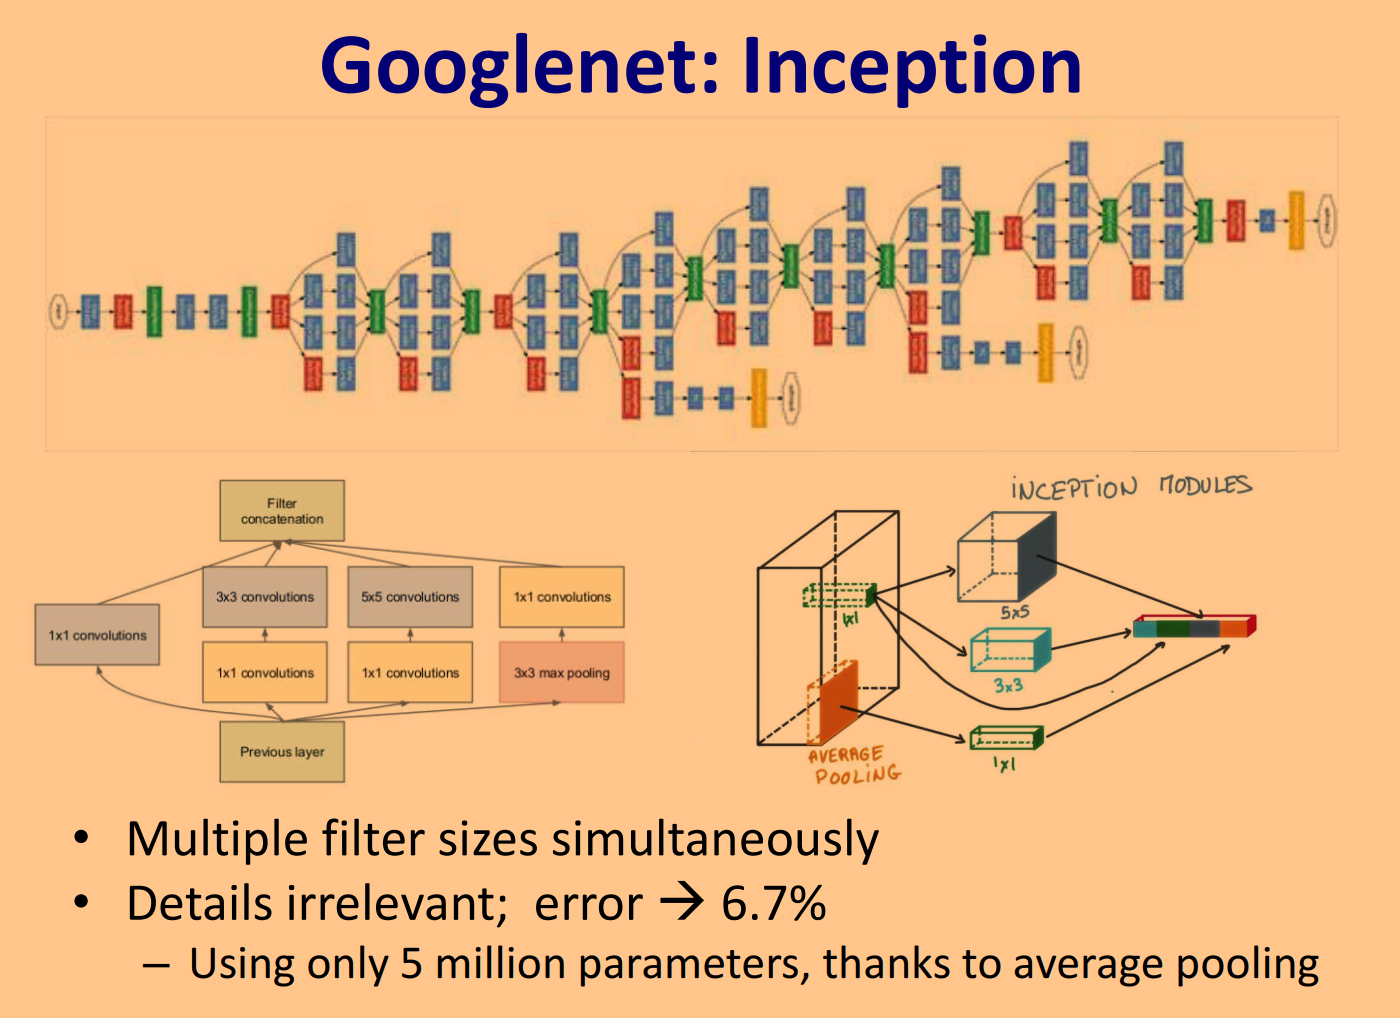

#### ResNet

- With over 150 layers: able to do that because of skip connections.

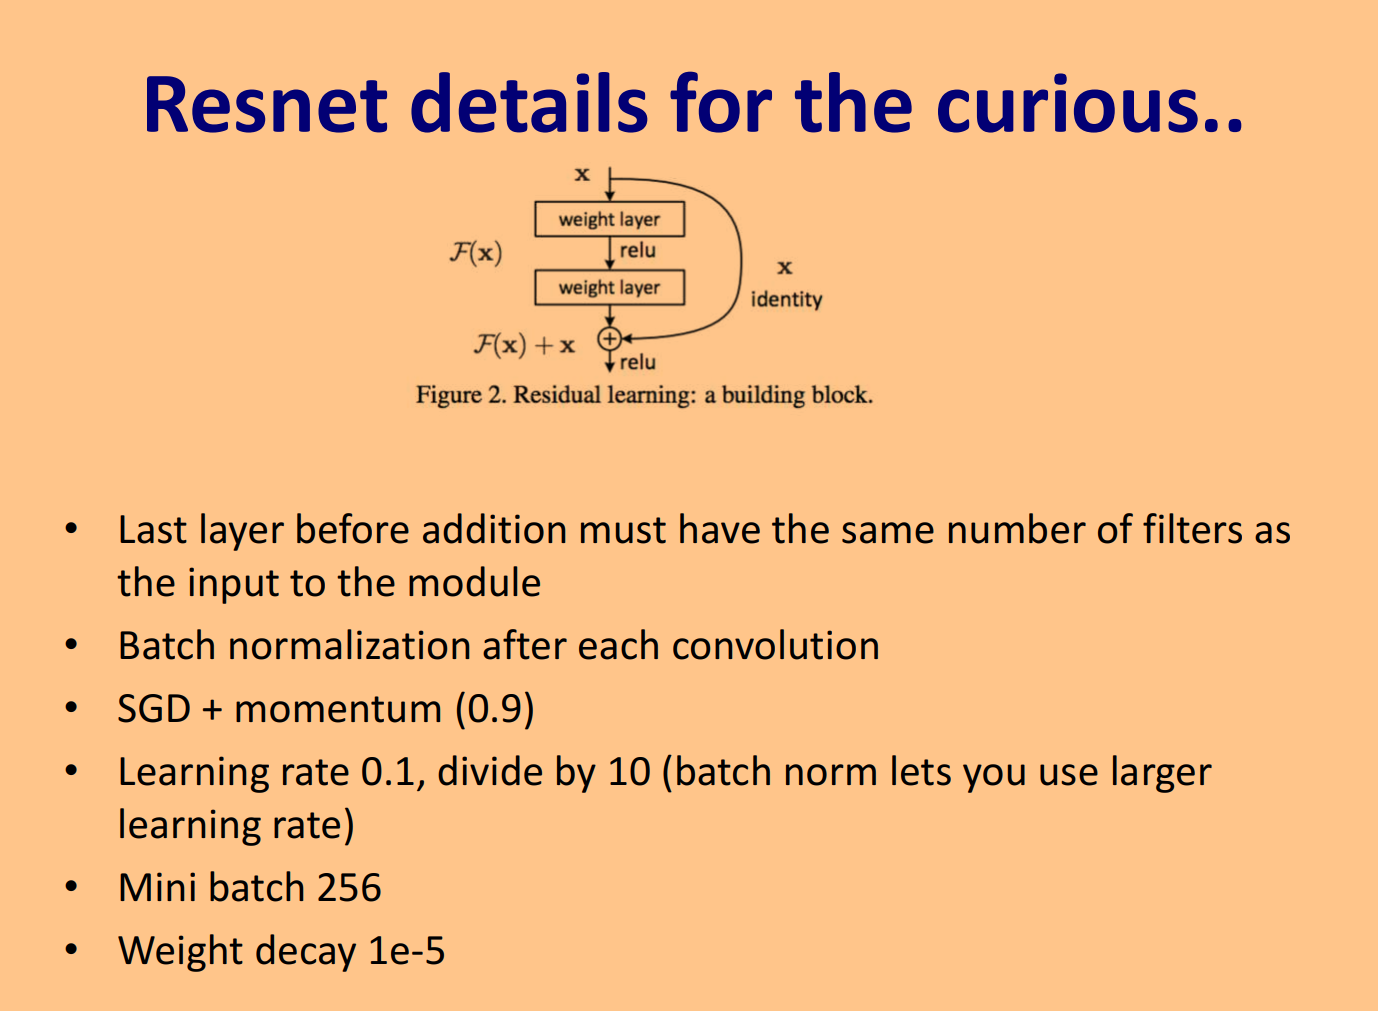


#### DenseNet

- All convolutional
- Each layer looks at the **union** of maps from all previous layers, instead of the immediate previous.

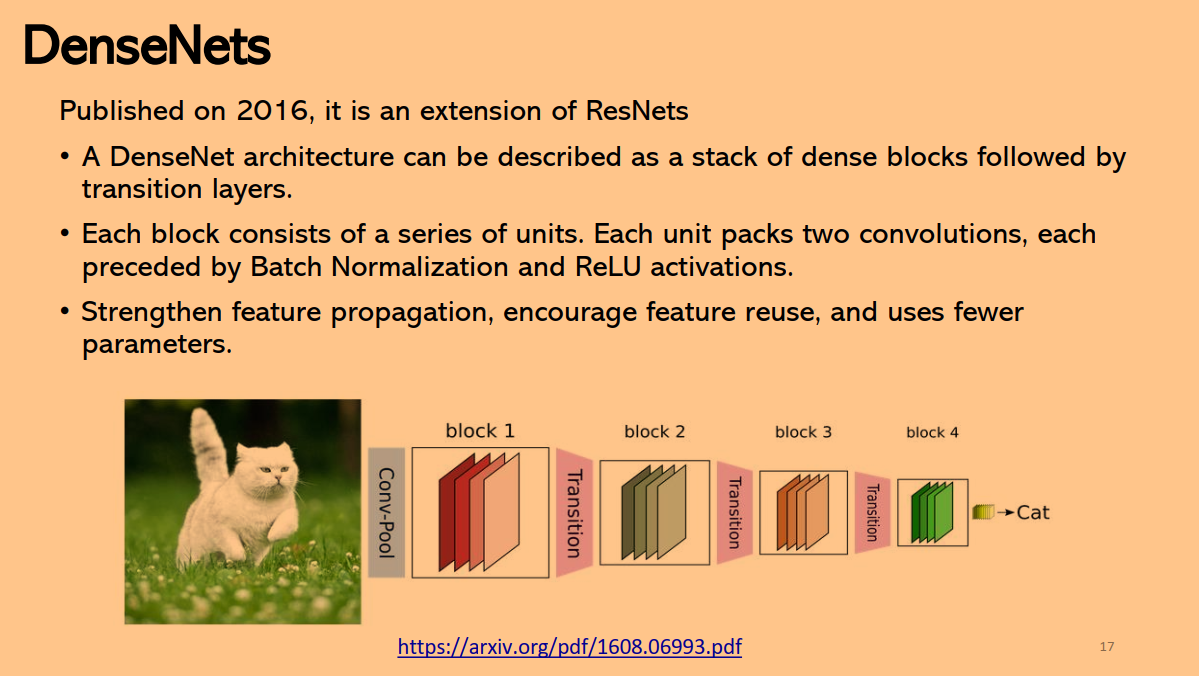


There are other variants mentioned in Recitation 5 and 6 of the CMU Deep Learning Course Fall 2019, such as Mobile Nets and Shuffle Nets

## Theoretical Properties

- The scanning block of convelutional layers can be distributed over multiple layers of the network, resulting in significant reduction in the total number of parameters.
- CNN is suited to serve as 'position-invariant' classifier, such as 'is there a cat somewhere in the picture' or 'is the word welcome in this speech'? That is something that fully-connected MLP cannot do.
- For ordinary MLP, 3-layer neural net may outperforms 2-layer ones, but going deeper (4,5,6-layer) does not seem to help, or probably it requires exponentially large number of neurons to learn everything. On the contrary, depth in CNN has been found to be extremely important, at least in image recognition. The intuition to this is perhaps again CNN's capability in identifying the local structures.

### Advantages and Disadvantages (might refer to the table in Section 10.7 in ESL)

### Relation to Other Models

## Empirical Performance

### Advantages and Disadvantages

## Implementation Details and Practical Tricks

In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels]. A mini-batch is represented as a 4D tensor of shape [mini-batch size, height, width, channels]. The weights of a convolutional layer are represented as a 4D tensor of shape $[f_h, f_w, f_n′, f_n]$. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape $[f_n]$.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

Create filters using Keras so that they are trainable. The below has 32 filters, each 3x3, with stride=1 both horizontally and vertically, and 'same' padding with relu activation.

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="same", activation="relu")

Pooling can be done using keras as well. The following code creates a max pooling layer using a 2 × 2 kernel. The strides default to the kernel size, so this layer will use a stride of 2 (both horizontally and vertically). By default, it uses "valid" padding (i.e., no padding at all)

In [2]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

`keras` does not include a depthwise max pooling layer, but `tensorFlow`’s low-level Deep Learning API does: just use the `tf.nn.max_pool()` function, and specify the kernel size and strides as 4-tuples  (i.e., tuples of size 4). The first three values of each should be 1: this indicates that the kernel size and stride along the batch, height, and width dimensions should be 1. The last value should be whatever kernel size and stride you want along the depth dimension—for example, 3 (this must be a divisor of the input depth; it will not work if the previous layer outputs 20 feature maps, since 20 is not a multiple of 3)

In [ ]:
output = tf.nn.max_pool(images,
                        ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="valid")

# Or you can wrap it around a lambda; see https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                             padding="valid"))

In the above, `padding` must be either `"same"` or `"valid"`.

- If set to `"same"`, the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up.
- If set to "valid", the convolutional layer does not use zero padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride.

See figure below.

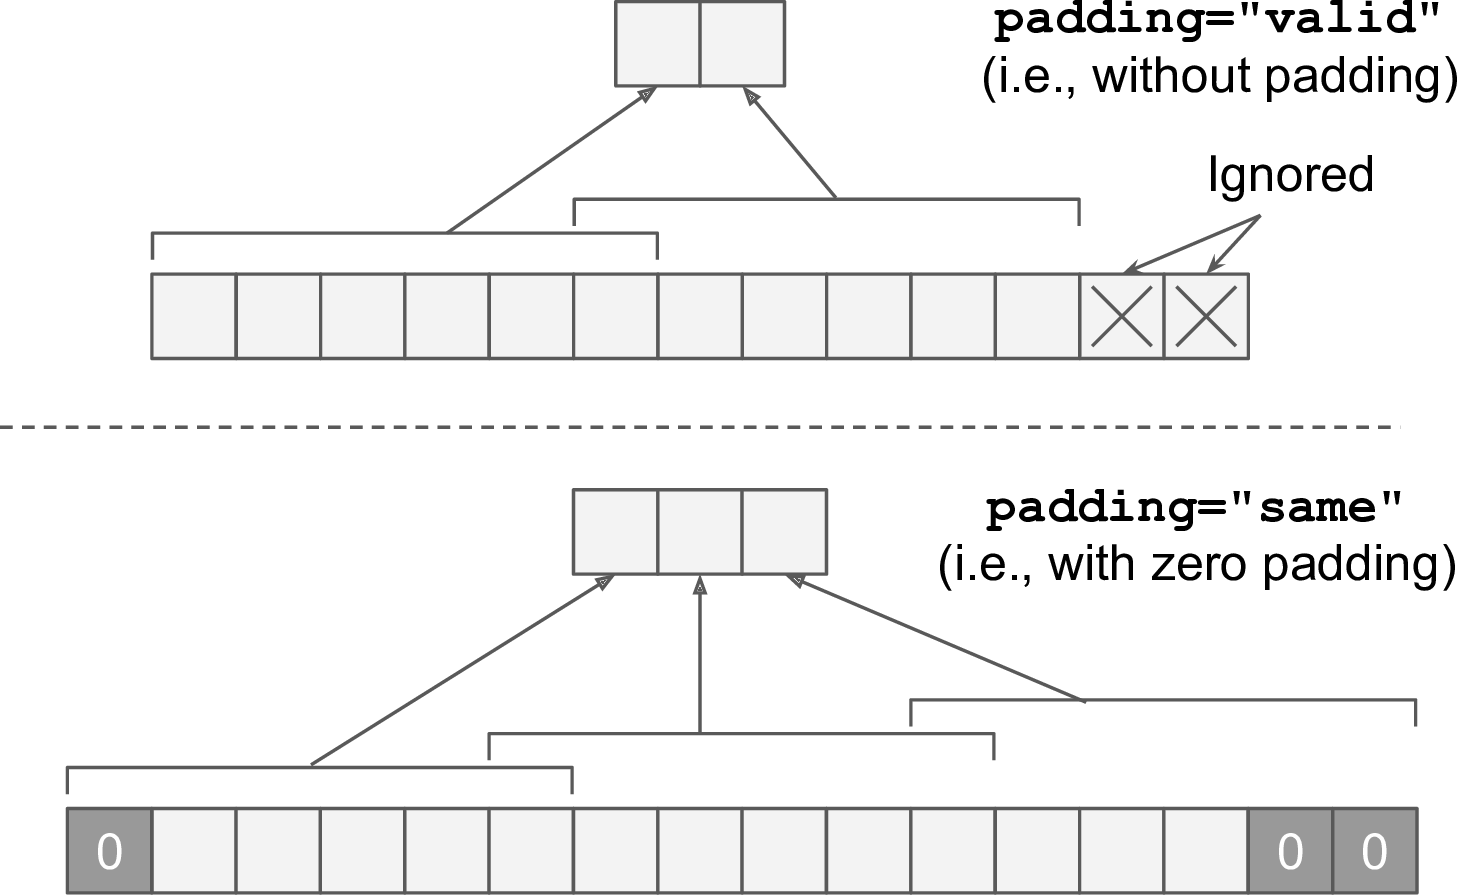

### Memory Requirements

One thing to keep in mind when training CNN is it is intensive of memory. During inference (i.e., when making a prediction for a new instance) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by two consecutive layers. But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers.

### Data Augmentation for Image Recognition

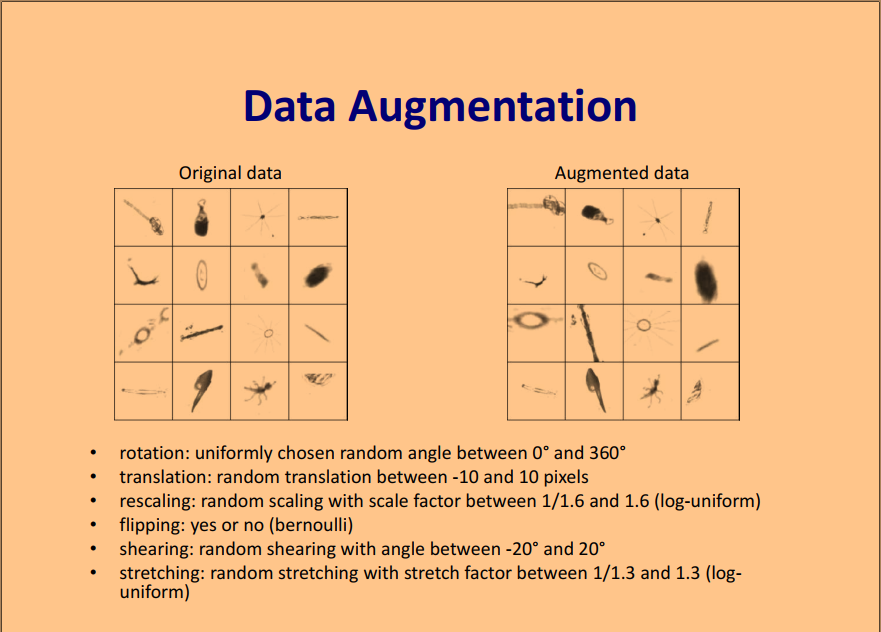

### Tapering

- Memory optimization technique: layers near the input can have higher filter sizes and larger strides
- Reduce filter sizes and strides as the network goes deeper.

## Use Cases

This is mainly for image processing.

## Results Interpretation, Metrics and Visualization

One trick mentioned in Stanford 231n course is to plot the feature map to show what feature the kernel is identifying.

## References 

- CMU Deep Learning Course Fall 2019.
- Stanford 231n

### Further Reading

- Depth-wise Separable Convolution: see the paper MobileNets: Efficient Convolutional Neural Networks for
Mobile Vision Applications
- Introduction to Mobile Nets and Shuffle Nets in Recitation 6 of the CMU course above
- Several more recent architetures on the Hands-on book, such as Xception and SENet.
- Hands-on book has some examples to do localization, object detection, semantic segmentation of image processing, and there are some special architeture, such as fully convolutional networks, YOLO, etc.
- Also did not read the part about implementing transfer learning in keras.

## Misc.